# Todo

1. Load the dataset for 1 date, explore the different metrics (strike distribution, number of calls vs puts, expiry available, forward curve, etc)
2. For a given several maturities 𝑇_1,𝑇_2,𝑒𝑡𝑐, plot the implied volatility with respect to strike 𝐾, moneyness 𝑚, delta Δ for both calls and puts.
3. For a chosen maturity 𝑇*1, and using the associated 𝑆*𝑡,𝐹*𝑡,𝜎*(𝑚𝑘𝑡,𝑖) calibrate a SABR model. More precisely use Hagan’s formula (2002) and minimize the $SSE=\sum_{option\ i}\left(\sigma_{mkt,i}-\sigma_{SABR,i}\right)$ or MSE using scipy.minimize. You can use a L-BFGS-B solver.
   - Generalize to all the other smiles of this single day.
   - Using the tools provided compute the Black & Scholes (1973) greeks and prices, compare with initial values.
4. Repeat 3. but for an SSVI model Gatheral & Jacquier (2014) to get all the surface at once.
5. Generalize 3 or 4 to multiple days, compute the realized volatility for different windows.
6. Using the rule-based selection function explore the implied volatility structure through time and strikes, vs realized, skew etc.


In [1]:
# Setup auto reload
%load_ext autoreload
%autoreload 2

In [2]:
import logging

logging.basicConfig(level=logging.INFO, format="%(asctime)s | %(levelname)s | %(message)s")

from warnings import filterwarnings

filterwarnings("ignore")

import pandas as pd
import numpy as np

from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc("font", **{"size": 22})

from investment_lab.option_selection import select_options
from investment_lab.metrics.volatility import rolling_realized_volatility
from investment_lab.metrics.util import levels_to_returns
from investment_lab.data.option_db import OptionLoader, SPYOptionLoader, extract_spot_from_options
from investment_lab.data.rates_db import USRatesLoader
from investment_lab.pricing.black_scholes import black_scholes_price, black_scholes_greeks
from investment_lab.pricing.implied_volatility import implied_volatility_vectorized
from investment_lab.rates import compute_forward
from investment_lab.metrics.distance import mse, sse
from investment_lab.surface.sabr import SABRSmoother
from investment_lab.surface.ssvi import SSVISmoother

In [3]:
df_options = OptionLoader.load_data(
    datetime(2022, 1, 4),
    datetime(2022, 1, 4),
    process_kwargs={"ticker": "AAPL"},
)
df_options.head()

2026-01-25 16:08:56,619 | INFO | Reading between 2022-01-04 00:00:00 2022-01-04 00:00:00 from ..//data/optiondb_2016_2023.parquet


,spot,strike,expiration,delta,gamma,vega,theta,rho,implied_volatility,bid,ask,volume,call_put,option_id,mid,ticker,date,day_to_expiration,moneyness
137425,179.72,105.0,2022-01-07,0.99760,0.00019,0.00119,-0.02392,0.01073,1.96065,74.65,74.85,1.0,C,AAPL 20220107C105,74.750,AAPL,2022-01-04,3,0.584242
137426,179.72,110.0,2022-01-07,0.99732,0.00022,0.00186,-0.02303,0.01071,1.80137,69.65,69.85,0.0,C,AAPL 20220107C110,69.750,AAPL,2022-01-04,3,0.612063
137427,179.72,115.0,2022-01-07,0.99724,0.00028,0.00164,-0.02307,0.01166,1.65001,64.65,64.85,0.0,C,AAPL 20220107C115,64.750,AAPL,2022-01-04,3,0.639884
137428,179.72,120.0,2022-01-07,0.99471,0.00054,0.00250,-0.04105,0.01216,1.61633,59.60,59.95,10.0,C,AAPL 20220107C120,59.775,AAPL,2022-01-04,3,0.667705
137429,179.72,125.0,2022-01-07,0.99422,0.00060,0.00349,-0.04125,0.01248,1.46774,54.60,54.95,0.0,C,AAPL 20220107C125,54.775,AAPL,2022-01-04,3,0.695526


In [4]:
df_spot = extract_spot_from_options(df_options)
df_spot.head()

,date,spot
0,2022-01-04,179.72


In [5]:
df_rates = USRatesLoader.load_data(datetime(2022, 1, 4), datetime(2022, 1, 4))
df_rates.head()

2026-01-25 16:09:09,443 | INFO | Reading between 2022-01-04 00:00:00 2022-01-04 00:00:00 from ..//data/par-yield-curve-rates-2020-2023.csv


,date,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
503,2022-01-04,0.0006,0.0005,0.0008,NaN,0.0022,0.0038,0.0077,0.0102,0.0137,0.0157,0.0166,0.021,0.0207


In [6]:
df_options = compute_forward(df_options=df_options, df_rates=df_rates)
df_options.head()

,spot,strike,expiration,delta,gamma,vega,theta,rho,implied_volatility,bid,...,volume,call_put,option_id,mid,ticker,date,day_to_expiration,moneyness,risk_free_rate,forward
0,179.72,105.0,2022-01-07,0.99760,0.00019,0.00119,-0.02392,0.01073,1.96065,74.65,...,1.0,C,AAPL 20220107C105,74.750,AAPL,2022-01-04,3,0.584242,0.0006,179.720886
1,179.72,110.0,2022-01-07,0.99732,0.00022,0.00186,-0.02303,0.01071,1.80137,69.65,...,0.0,C,AAPL 20220107C110,69.750,AAPL,2022-01-04,3,0.612063,0.0006,179.720886
2,179.72,115.0,2022-01-07,0.99724,0.00028,0.00164,-0.02307,0.01166,1.65001,64.65,...,0.0,C,AAPL 20220107C115,64.750,AAPL,2022-01-04,3,0.639884,0.0006,179.720886
3,179.72,120.0,2022-01-07,0.99471,0.00054,0.00250,-0.04105,0.01216,1.61633,59.60,...,10.0,C,AAPL 20220107C120,59.775,AAPL,2022-01-04,3,0.667705,0.0006,179.720886
4,179.72,125.0,2022-01-07,0.99422,0.00060,0.00349,-0.04125,0.01248,1.46774,54.60,...,0.0,C,AAPL 20220107C125,54.775,AAPL,2022-01-04,3,0.695526,0.0006,179.720886


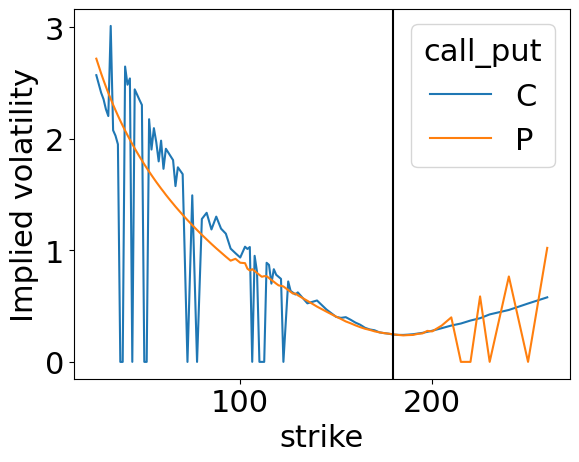

In [7]:
df_single_expiry = df_options.loc[df_options.expiration == "2022-01-21"]
ax = df_single_expiry.pivot_table(index="strike", columns="call_put", values="implied_volatility").sort_index().plot()
ax.set_xlabel("strike")
ax.set_ylabel("Implied volatility")
ax.axvline(x=df_single_expiry["spot"].iloc[0], label="spot", color="black")

Text(0, 0.5, 'Implied volatility')

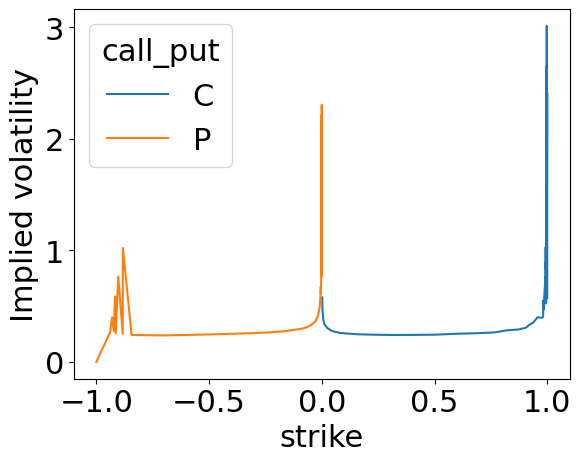

In [8]:
df_single_expiry = df_options.loc[df_options.expiration == "2022-01-21"]
ax = df_single_expiry.pivot_table(index="delta", columns="call_put", values="implied_volatility").sort_index().plot()
ax.set_xlabel("strike")
ax.set_ylabel("Implied volatility")
# ax.axvline(x=df_single_expiry['spot'].iloc[0],label="spot",color="black")

In [9]:
put_strike_filter = (df_single_expiry["call_put"] == "P") & (df_single_expiry["strike"] <= df_single_expiry["forward"])
call_strike_filter = (df_single_expiry["call_put"] == "C") & (df_single_expiry["strike"] >= df_single_expiry["forward"])

df_single_expiry_filtered = df_single_expiry.loc[put_strike_filter | call_strike_filter]


sabr_model = SABRSmoother(initial_params=(0.2, 0.75, -0.5, 0.2))
sabr_model = sabr_model.fit(
    df_single_expiry_filtered["forward"],
    df_single_expiry_filtered["strike"],
    df_single_expiry_filtered["day_to_expiration"] / 252,
    df_single_expiry_filtered["implied_volatility"],
)
df_single_expiry["implied_volatility_SABR"] = sabr_model.transform(
    df_single_expiry["forward"],
    df_single_expiry["strike"],
    df_single_expiry["day_to_expiration"] / 252,
)
df_single_expiry[["implied_volatility_SABR", "implied_volatility"]].head()

2026-01-25 16:09:10,450 | INFO | Fitting SABR model on 102 records
2026-01-25 16:09:10,454 | INFO | Initial guess: (0.2, 0.75, -0.5, 0.2)
2026-01-25 16:09:10,455 | INFO | Parameter bounds: [(1e-06, None), (0, 1), (-0.999, 0.999), (1e-06, None)]
2026-01-25 16:09:10,457 | INFO | Solver: L-BFGS-B
2026-01-25 16:09:12,278 | INFO | Successfully fitted SABR Model. Found the following Parameters [0.76315187 0.57880191 0.00748631 6.34640675]


,implied_volatility_SABR,implied_volatility
196,2.557070,2.56974
197,2.453765,2.41264
198,2.405255,2.35488
199,2.358613,2.26471
200,2.313694,2.20327


<Axes: xlabel='implied_volatility', ylabel='implied_volatility_SABR'>

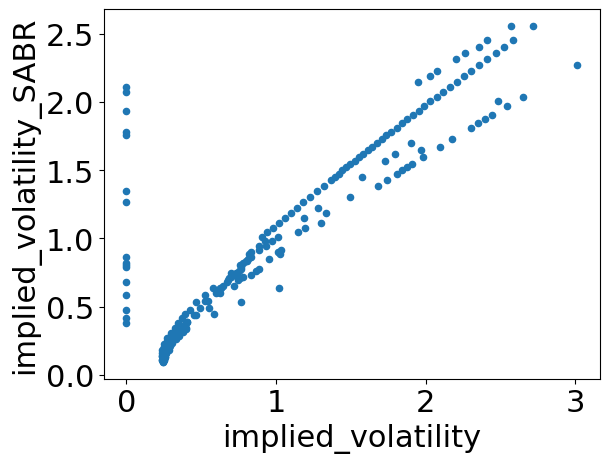

In [10]:
df_single_expiry[["implied_volatility_SABR", "implied_volatility"]].plot.scatter(x="implied_volatility", y="implied_volatility_SABR")

Text(0, 0.5, 'Implied volatility')

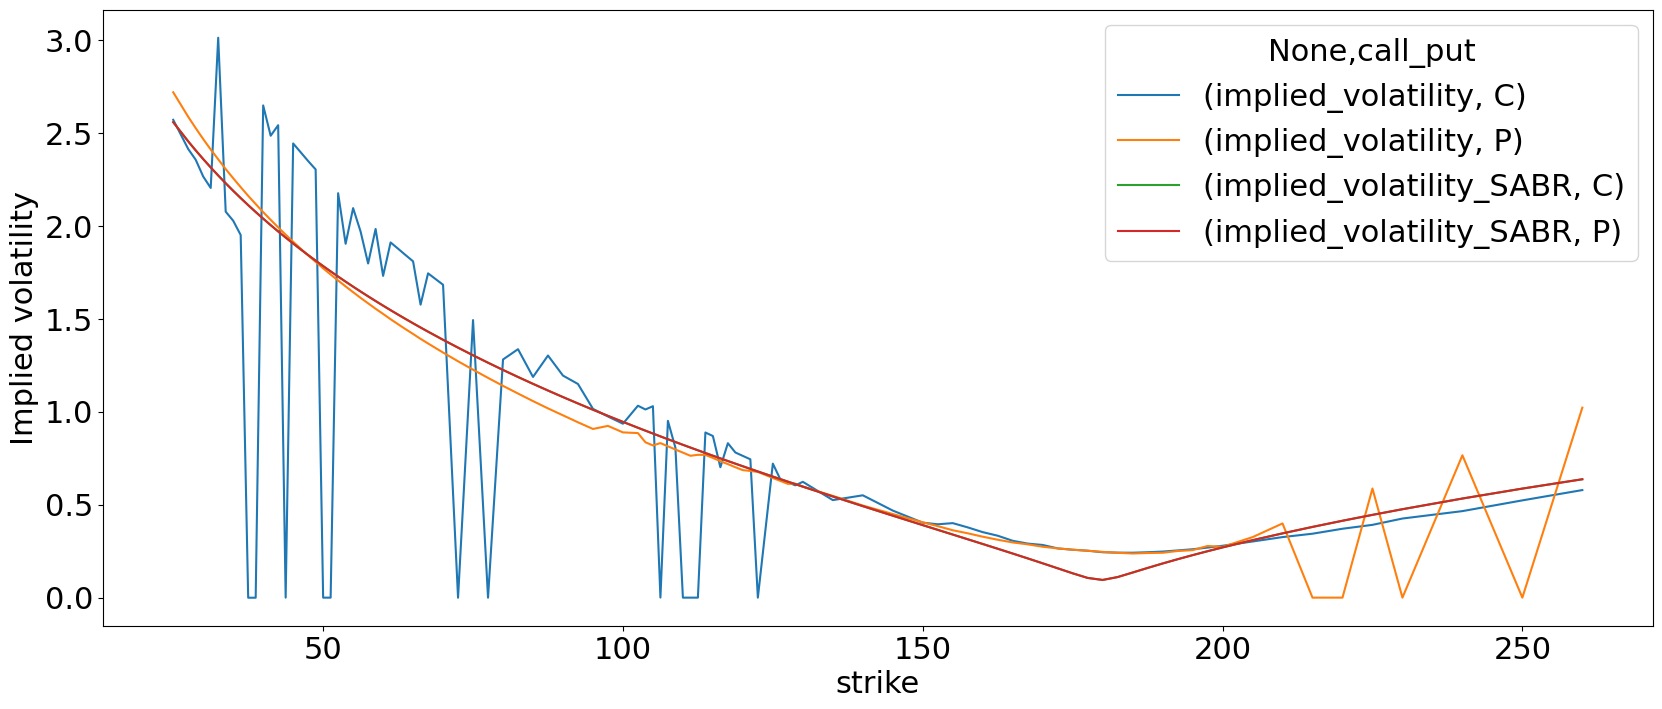

In [11]:
ax = (
    df_single_expiry.pivot_table(index="strike", columns="call_put", values=["implied_volatility_SABR", "implied_volatility"])
    .sort_index()
    .plot(figsize=(20, 8))
)
ax.set_xlabel("strike")
ax.set_ylabel("Implied volatility")

In [12]:
put_strike_filter = (df_options["call_put"] == "P") & (df_options["strike"] <= df_options["forward"])
call_strike_filter = (df_options["call_put"] == "C") & (df_options["strike"] >= df_options["forward"])

df_options_filtered = df_options.loc[put_strike_filter | call_strike_filter]


ssvi_model = SSVISmoother(initial_params=(0.2, -0.4, 0.2, 0.4))  # sigma, rho, eta, lamb
ssvi_model = ssvi_model.fit(
    df_options_filtered["forward"],
    df_options_filtered["strike"],
    df_options_filtered["day_to_expiration"] / 252,
    df_options_filtered["implied_volatility"],
)
total_variance_SSVI = ssvi_model.transform(
    df_options["forward"],
    df_options["strike"],
    df_options["day_to_expiration"] / 252,
)
df_options["implied_volatility_SSVI"] = np.sqrt(total_variance_SSVI / (df_options["day_to_expiration"] / 252))
df_options[["implied_volatility_SSVI", "implied_volatility"]].head()

2026-01-25 16:09:13,294 | INFO | Fitting SSVI model on 855 records
2026-01-25 16:09:13,296 | INFO | Initial guess: (0.2, -0.4, 0.2, 0.4)
2026-01-25 16:09:13,297 | INFO | Parameter bounds: [(1e-05, None), (-0.999, 0.999), (1e-06, 5.0), (1e-06, 0.5)]
2026-01-25 16:09:13,298 | INFO | Solver: L-BFGS-B


,implied_volatility_SSVI,implied_volatility
0,1.173977,1.96065
1,1.123520,1.80137
2,1.073096,1.65001
3,1.022496,1.61633
4,0.971496,1.46774


In [13]:
df_options.expiration.unique()

<DatetimeArray>
['2022-01-07 00:00:00', '2022-01-14 00:00:00', '2022-01-21 00:00:00',
 '2022-01-28 00:00:00', '2022-02-04 00:00:00', '2022-02-11 00:00:00',
 '2022-02-18 00:00:00', '2022-03-18 00:00:00', '2022-04-14 00:00:00',
 '2022-05-20 00:00:00', '2022-06-17 00:00:00', '2022-07-15 00:00:00',
 '2022-09-16 00:00:00', '2023-01-20 00:00:00', '2023-03-17 00:00:00',
 '2023-06-16 00:00:00', '2023-09-15 00:00:00', '2024-01-19 00:00:00']
Length: 18, dtype: datetime64[ns]

Text(0, 0.5, 'Implied volatility')

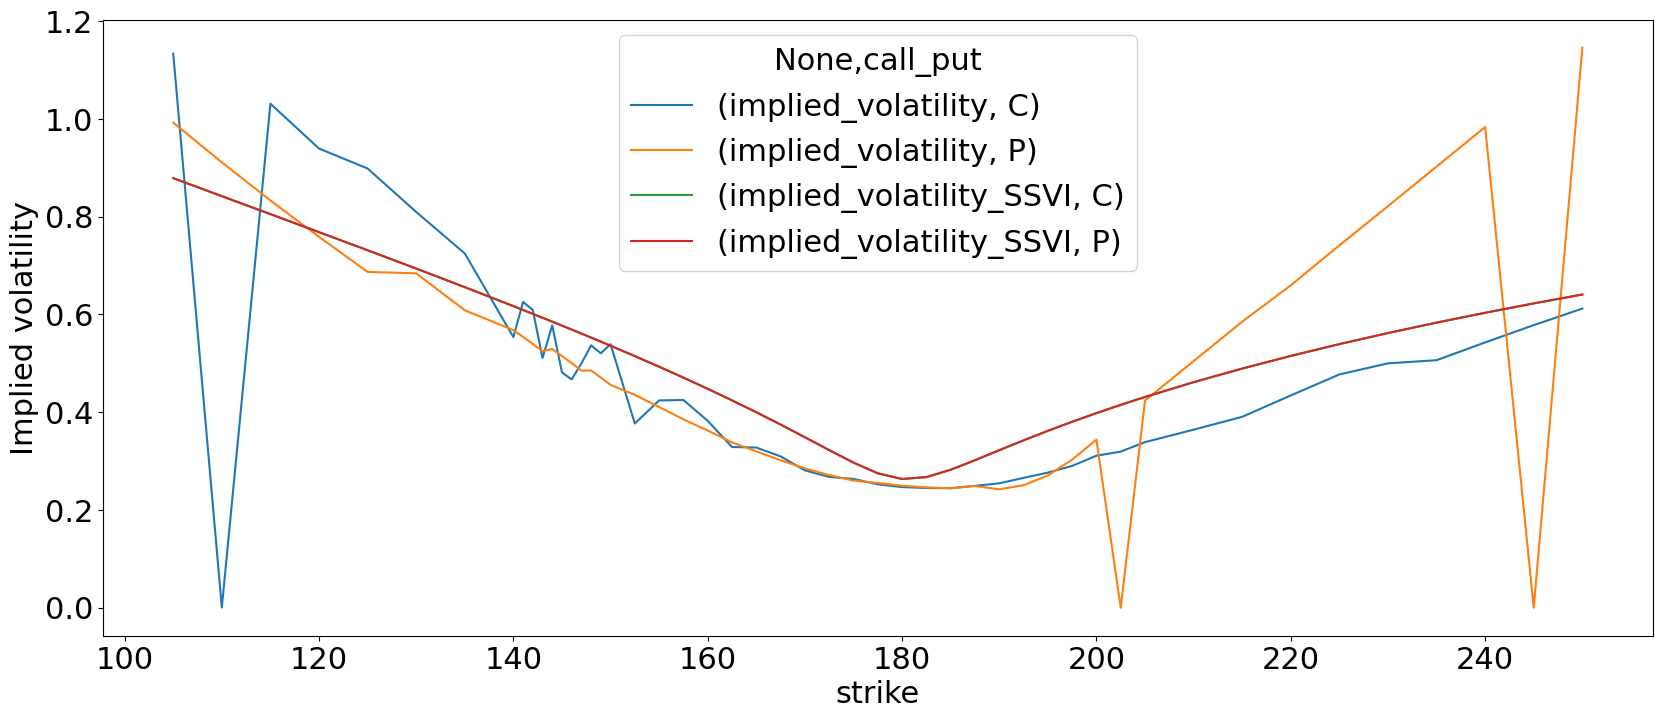

In [14]:
ax = (
    df_options[df_options.expiration == "2022-01-14"]
    .pivot_table(index="strike", columns="call_put", values=["implied_volatility_SSVI", "implied_volatility"])
    .sort_index()
    .plot(figsize=(20, 8))
)
ax.set_xlabel("strike")
ax.set_ylabel("Implied volatility")

<Axes: xlabel='implied_volatility', ylabel='implied_volatility_SSVI'>

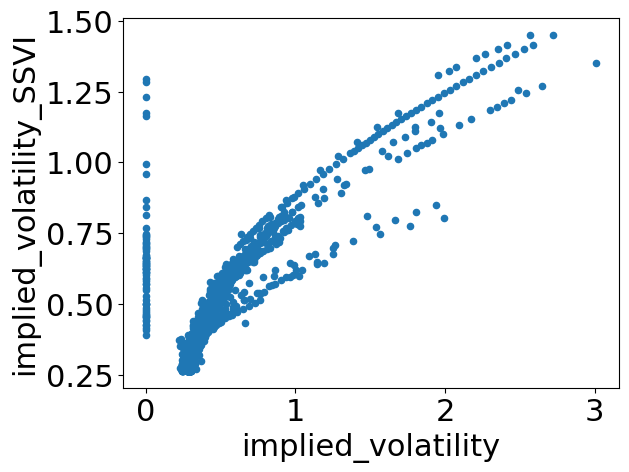

In [15]:
df_options.plot.scatter(x="implied_volatility", y="implied_volatility_SSVI")

## 3D Surface


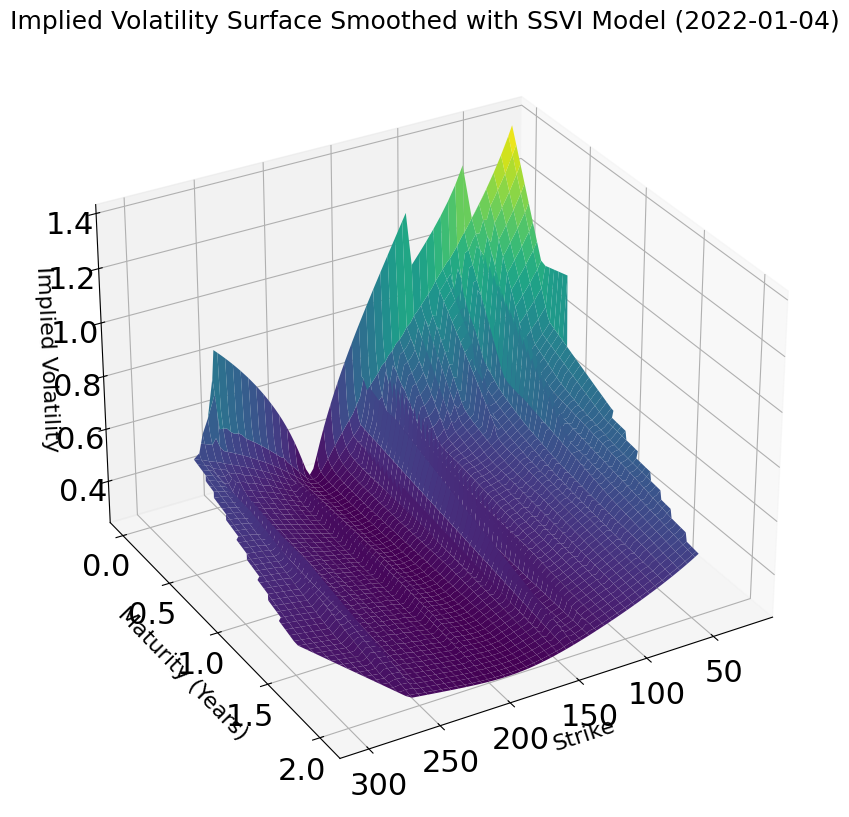

In [16]:
import scipy.interpolate as interp

df_options_copy = df_options.copy()
# df_options_copy = df_options_copy[df_options_copy["moneyness"].between(0.8, 1.2)]
# df_options_copy = df_options_copy[df_options_copy["day_to_expiration"].between(1, 365.25)]

put_strike_filter = (df_options_copy["call_put"] == "P") & (df_options_copy["strike"] <= df_options_copy["forward"])
call_strike_filter = (df_options_copy["call_put"] == "C") & (df_options_copy["strike"] >= df_options_copy["forward"])

df_options_copy = df_options_copy[put_strike_filter | call_strike_filter]

strikes = df_options_copy["strike"].values
expirations = df_options_copy["day_to_expiration"].values / 365.25
implied_volatility = df_options_copy["implied_volatility_SSVI"].values

# Create grid
strike_grid, exp_grid = np.meshgrid(np.linspace(strikes.min(), strikes.max(), 100), np.linspace(expirations.min(), expirations.max(), 100))

# Interpolate
vol_grid = interp.griddata((strikes, expirations), implied_volatility, (strike_grid, exp_grid), method="linear")

# Plot 3D surface
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(strike_grid, exp_grid, vol_grid, cmap="viridis", edgecolor="none")
ax.set_xlabel("Strike", fontsize=16)
ax.set_ylabel("Maturity (Years)", fontsize=16)
ax.set_zlabel("Implied Volatility", fontsize=16)
ax.set_title("Implied Volatility Surface Smoothed with SSVI Model (2022-01-04)", fontsize=18)
ax.view_init(elev=30, azim=60)  # Adjust azimuth and elevation as needed

# Reprice the dataset and see


In [17]:
df_options["mid_BS"] = black_scholes_price(
    S=df_options["spot"],
    K=df_options["strike"],
    option_type=df_options["call_put"],
    r=df_options["risk_free_rate"],
    T=df_options["day_to_expiration"] / 365.25,
    sigma=df_options["implied_volatility_SSVI"],
)
df_options[["delta_BS", "gamma_BS", "vega_BS", "theta_BS", "rho_BS"]] = black_scholes_greeks(
    S=df_options["spot"],
    K=df_options["strike"],
    option_type=df_options["call_put"],
    r=df_options["risk_free_rate"],
    T=df_options["day_to_expiration"] / 365.25,
    sigma=df_options["implied_volatility_SSVI"],
)
df_options.head()

,spot,strike,expiration,delta,gamma,vega,theta,rho,implied_volatility,bid,...,moneyness,risk_free_rate,forward,implied_volatility_SSVI,mid_BS,delta_BS,gamma_BS,vega_BS,theta_BS,rho_BS
0,179.72,105.0,2022-01-07,0.99760,0.00019,0.00119,-0.02392,0.01073,1.96065,74.65,...,0.584242,0.0006,179.720886,1.173977,74.720518,1.000000,4.584369e-08,0.000014,-0.064020,0.862418
1,179.72,110.0,2022-01-07,0.99732,0.00022,0.00186,-0.02303,0.01071,1.80137,69.65,...,0.612063,0.0006,179.720886,1.123520,69.720544,0.999999,1.526250e-07,0.000045,-0.069111,0.903485
2,179.72,115.0,2022-01-07,0.99724,0.00028,0.00164,-0.02307,0.01166,1.65001,64.65,...,0.639884,0.0006,179.720886,1.073096,64.720573,0.999998,4.835201e-07,0.000138,-0.077991,0.944551
3,179.72,120.0,2022-01-07,0.99471,0.00054,0.00250,-0.04105,0.01216,1.61633,59.60,...,0.667705,0.0006,179.720886,1.022496,59.720610,0.999995,1.464587e-06,0.000397,-0.096728,0.985613
4,179.72,125.0,2022-01-07,0.99422,0.00060,0.00349,-0.04125,0.01248,1.46774,54.60,...,0.695526,0.0006,179.720886,0.971496,54.720670,0.999985,4.259874e-06,0.001098,-0.139927,1.026666


array([[<Axes: title={'center': 'delta_BS'}>,
        <Axes: title={'center': 'delta'}>]], dtype=object)

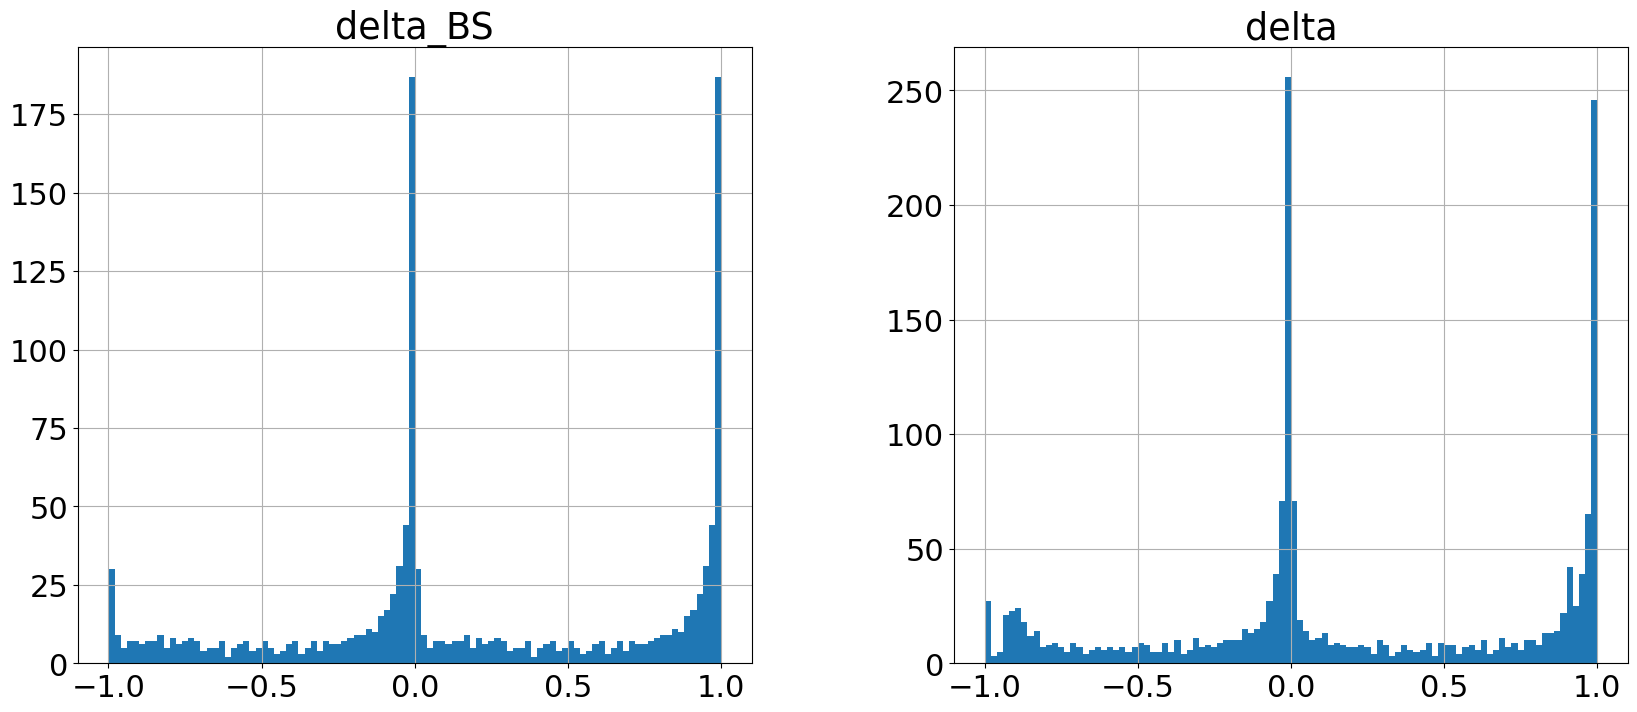

In [18]:
df_options[["delta_BS", "delta"]].hist(bins=100, figsize=(20, 8))

<Axes: title={'center': 'Rho'}, xlabel='Market', ylabel='Black Scholes'>

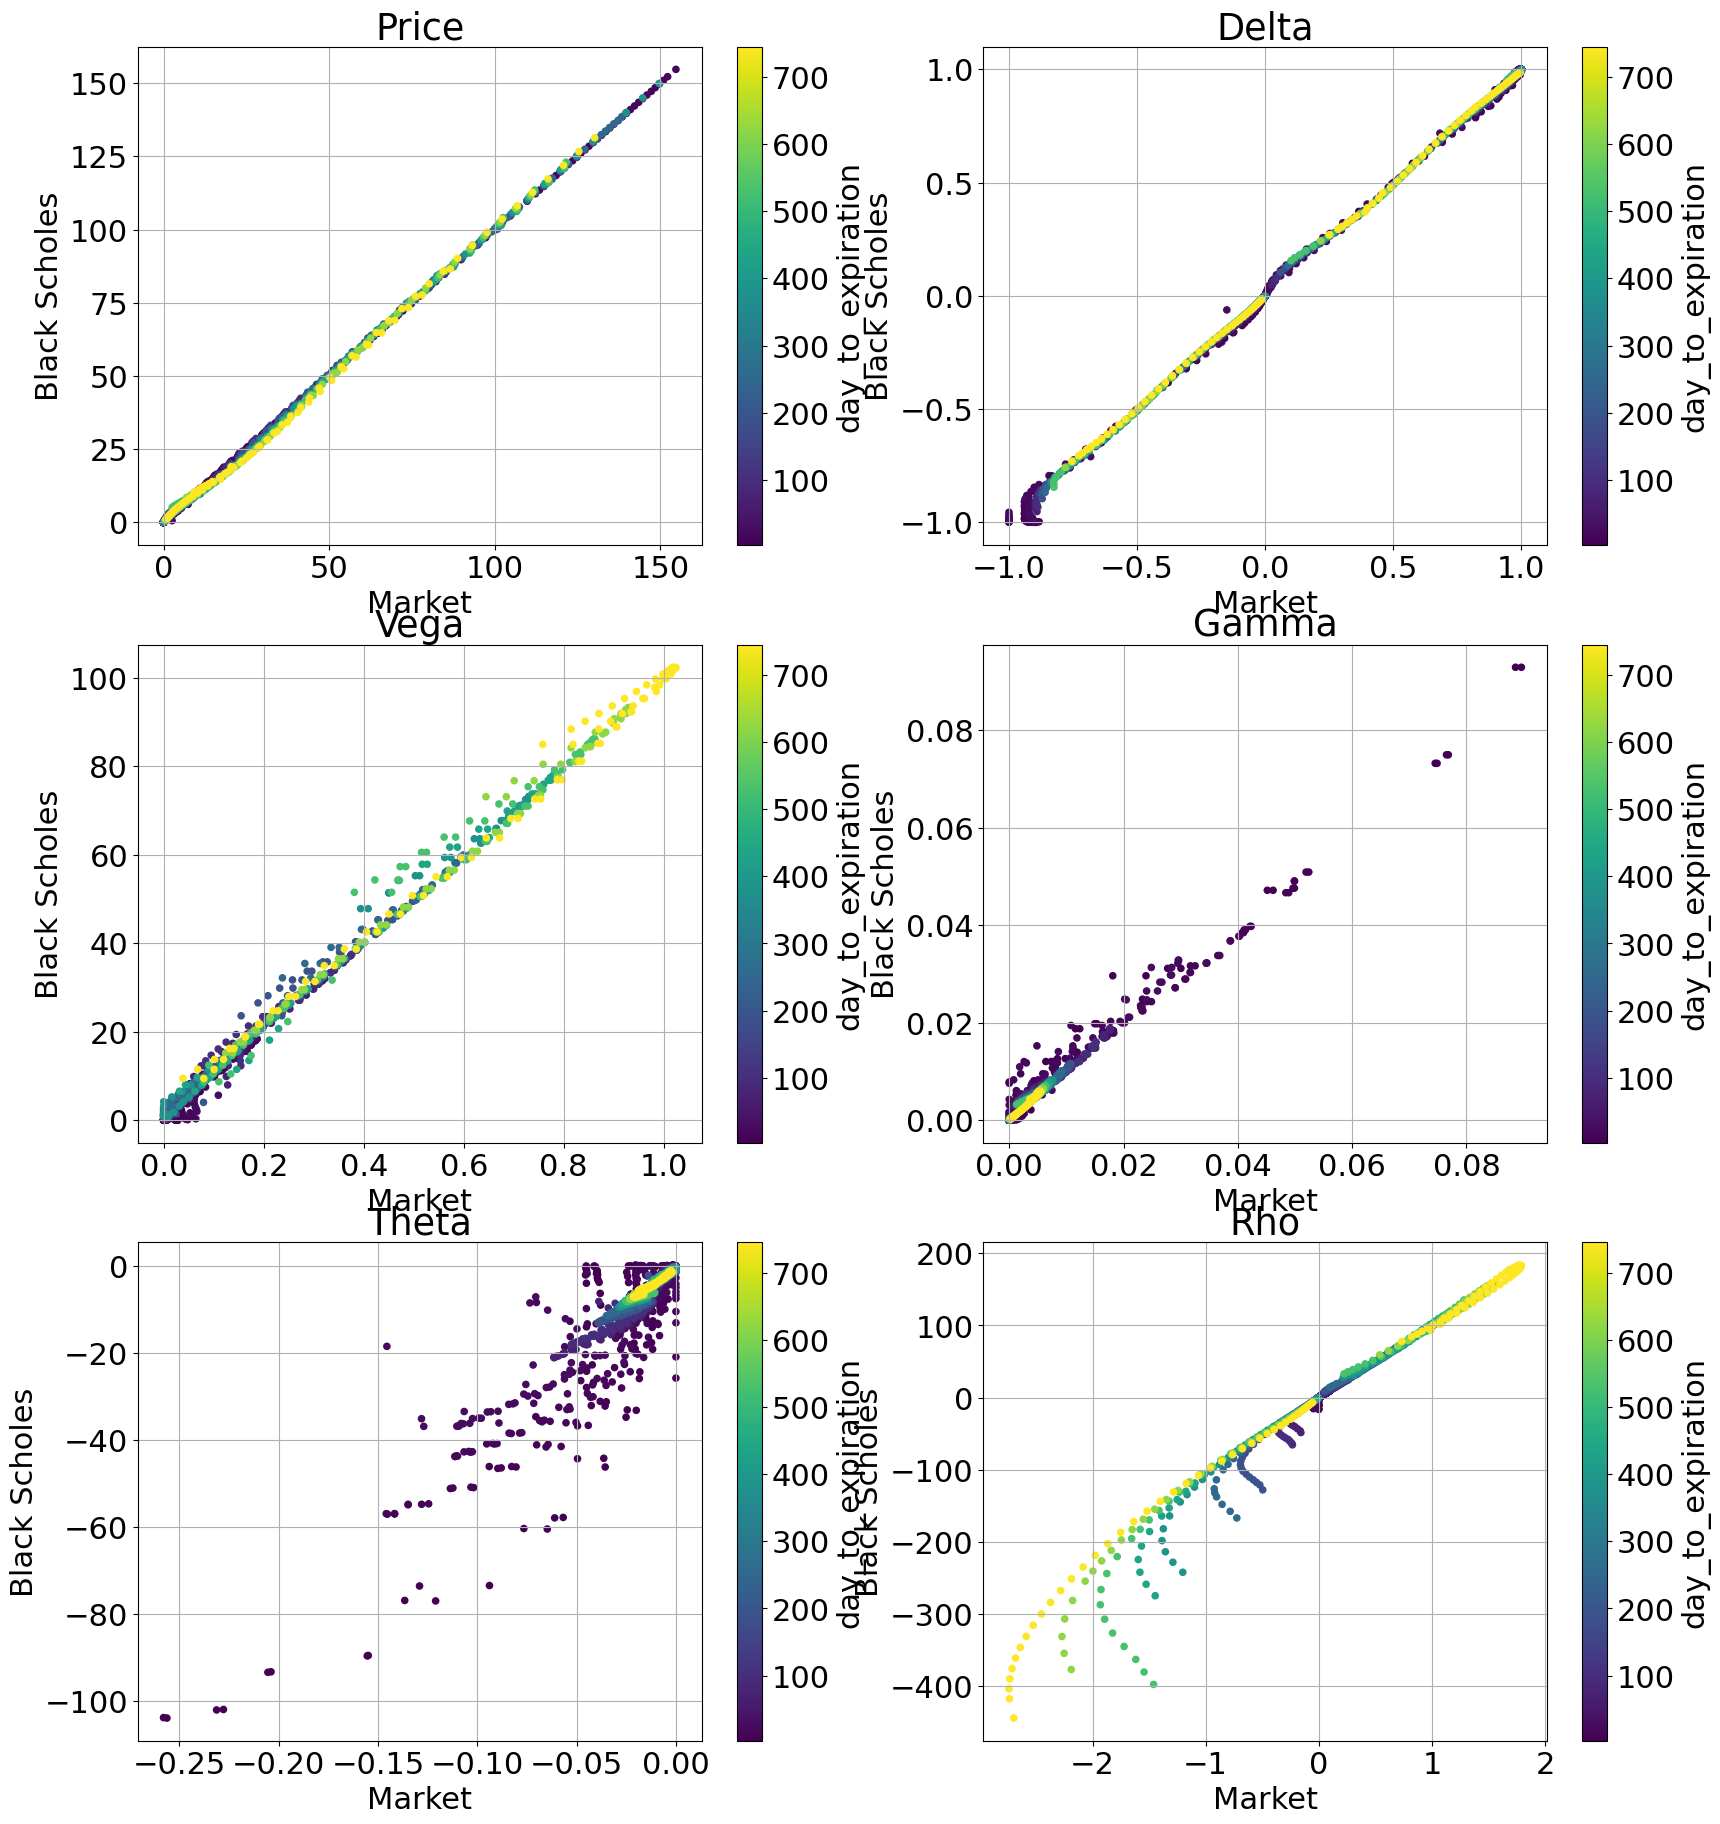

In [19]:
fig, (ax, ax2, ax3) = plt.subplots(3, 2, figsize=(20, 22))

df_options.plot.scatter(
    x="mid", y="mid_BS", grid=True, c="day_to_expiration", cmap="viridis", ax=ax[0], title="Price", ylabel="Black Scholes", xlabel="Market"
)
df_options.plot.scatter(
    x="delta", y="delta_BS", grid=True, c="day_to_expiration", cmap="viridis", ax=ax[1], title="Delta", ylabel="Black Scholes", xlabel="Market"
)
df_options.plot.scatter(
    x="vega", y="vega_BS", grid=True, c="day_to_expiration", cmap="viridis", ax=ax2[0], title="Vega", ylabel="Black Scholes", xlabel="Market"
)
df_options.plot.scatter(
    x="gamma", y="gamma_BS", grid=True, c="day_to_expiration", cmap="viridis", ax=ax2[1], title="Gamma", ylabel="Black Scholes", xlabel="Market"
)
df_options.plot.scatter(
    x="theta", y="theta_BS", grid=True, c="day_to_expiration", cmap="viridis", ax=ax3[0], title="Theta", ylabel="Black Scholes", xlabel="Market"
)
df_options.plot.scatter(
    x="rho", y="rho_BS", grid=True, c="day_to_expiration", cmap="viridis", ax=ax3[1], title="Rho", ylabel="Black Scholes", xlabel="Market"
)

# Time Series Calibration


In [20]:
df_options = OptionLoader.load_data(
    datetime(2020, 1, 4),
    datetime(2020, 12, 4),
    process_kwargs={"ticker": "AAPL"},
)
print(df_options.shape)
df_options.head()

2026-01-25 16:09:18,633 | INFO | Reading between 2020-01-04 00:00:00 2020-12-04 00:00:00 from ..//data/optiondb_2016_2023.parquet


(545254, 19)


,spot,strike,expiration,delta,gamma,vega,theta,rho,implied_volatility,bid,ask,volume,call_put,option_id,mid,ticker,date,day_to_expiration,moneyness
169768,299.8,200.0,2020-01-10,1.00000,0.00000,0.00000,-0.00004,0.02788,0.00000,99.15,99.95,0.0,C,AAPL 20200110C200,99.550,AAPL,2020-01-06,4,0.667111
169769,299.8,205.0,2020-01-10,0.99821,0.00015,0.00173,-0.01508,0.02786,1.13225,94.56,95.05,2.0,C,AAPL 20200110C205,94.805,AAPL,2020-01-06,4,0.683789
169770,299.8,210.0,2020-01-10,0.99075,0.00057,0.00840,-0.08789,0.02864,1.32704,89.65,90.20,0.0,C,AAPL 20200110C210,89.925,AAPL,2020-01-06,4,0.700467
169771,299.8,215.0,2020-01-10,0.99618,0.00028,0.00362,-0.03106,0.02948,1.08562,84.70,84.95,5.0,C,AAPL 20200110C215,84.825,AAPL,2020-01-06,4,0.717145
169772,299.8,220.0,2020-01-10,1.00000,0.00000,0.00000,-0.00048,0.03037,0.00000,79.34,80.05,0.0,C,AAPL 20200110C220,79.695,AAPL,2020-01-06,4,0.733823


In [21]:
df_rates = USRatesLoader.load_data(
    datetime(2020, 1, 4),
    datetime(2020, 12, 4),
)
df_options = compute_forward(df_options=df_options, df_rates=df_rates)
df_options.head()

2026-01-25 16:09:32,424 | INFO | Reading between 2020-01-04 00:00:00 2020-12-04 00:00:00 from ..//data/par-yield-curve-rates-2020-2023.csv


,spot,strike,expiration,delta,gamma,vega,theta,rho,implied_volatility,bid,...,volume,call_put,option_id,mid,ticker,date,day_to_expiration,moneyness,risk_free_rate,forward
0,299.8,200.0,2020-01-10,1.00000,0.00000,0.00000,-0.00004,0.02788,0.00000,99.15,...,0.0,C,AAPL 20200110C200,99.550,AAPL,2020-01-06,4,0.667111,0.0154,299.850566
1,299.8,205.0,2020-01-10,0.99821,0.00015,0.00173,-0.01508,0.02786,1.13225,94.56,...,2.0,C,AAPL 20200110C205,94.805,AAPL,2020-01-06,4,0.683789,0.0154,299.850566
2,299.8,210.0,2020-01-10,0.99075,0.00057,0.00840,-0.08789,0.02864,1.32704,89.65,...,0.0,C,AAPL 20200110C210,89.925,AAPL,2020-01-06,4,0.700467,0.0154,299.850566
3,299.8,215.0,2020-01-10,0.99618,0.00028,0.00362,-0.03106,0.02948,1.08562,84.70,...,5.0,C,AAPL 20200110C215,84.825,AAPL,2020-01-06,4,0.717145,0.0154,299.850566
4,299.8,220.0,2020-01-10,1.00000,0.00000,0.00000,-0.00048,0.03037,0.00000,79.34,...,0.0,C,AAPL 20200110C220,79.695,AAPL,2020-01-06,4,0.733823,0.0154,299.850566


In [24]:
def daily_vol_calibration(df_day_group: pd.DataFrame) -> pd.DataFrame:
    put_strike_filter = (df_day_group["call_put"] == "P") & (df_day_group["strike"] <= df_day_group["forward"])
    call_strike_filter = (df_day_group["call_put"] == "C") & (df_day_group["strike"] >= df_day_group["forward"])
    df_options_filtered = df_day_group.loc[put_strike_filter | call_strike_filter]

    ssvi_model = SSVISmoother(initial_params=(0.2, -0.4, 0.2, 0.4))  # sigma, rho, eta, lamb
    ssvi_model = ssvi_model.fit(
        df_options_filtered["forward"],
        df_options_filtered["strike"],
        df_options_filtered["day_to_expiration"] / 252,
        df_options_filtered["implied_volatility"],
    )
    total_variance_SSVI = ssvi_model.transform(
        df_day_group["forward"],
        df_day_group["strike"],
        df_day_group["day_to_expiration"] / 252,
    )
    df_day_group["implied_volatility_SSVI"] = np.sqrt(total_variance_SSVI / (df_day_group["day_to_expiration"] / 252))

    return df_day_group


df_options_calibrated = df_options.groupby("date").apply(daily_vol_calibration).reset_index(drop=True)
df_options_calibrated.head()

2026-01-25 16:12:28,027 | INFO | Fitting SSVI model on 967 records
2026-01-25 16:12:28,028 | INFO | Initial guess: (0.2, -0.4, 0.2, 0.4)
2026-01-25 16:12:28,028 | INFO | Parameter bounds: [(1e-05, None), (-0.999, 0.999), (1e-06, 5.0), (1e-06, 0.5)]
2026-01-25 16:12:28,029 | INFO | Solver: L-BFGS-B
2026-01-25 16:12:28,104 | INFO | Successfully fitted SSVI Model. Found the following Parameters [ 0.23383667 -0.17672501  1.33989482  0.5       ]
2026-01-25 16:12:28,112 | INFO | Fitting SSVI model on 975 records
2026-01-25 16:12:28,115 | INFO | Initial guess: (0.2, -0.4, 0.2, 0.4)
2026-01-25 16:12:28,117 | INFO | Parameter bounds: [(1e-05, None), (-0.999, 0.999), (1e-06, 5.0), (1e-06, 0.5)]
2026-01-25 16:12:28,118 | INFO | Solver: L-BFGS-B
2026-01-25 16:12:28,261 | INFO | Successfully fitted SSVI Model. Found the following Parameters [ 0.23535328 -0.16406737  1.34121295  0.5       ]
2026-01-25 16:12:28,267 | INFO | Fitting SSVI model on 999 records
2026-01-25 16:12:28,269 | INFO | Initial gu

,spot,strike,expiration,delta,gamma,vega,theta,rho,implied_volatility,bid,...,call_put,option_id,mid,ticker,date,day_to_expiration,moneyness,risk_free_rate,forward,implied_volatility_SSVI
0,299.8,200.0,2020-01-10,1.00000,0.00000,0.00000,-0.00004,0.02788,0.00000,99.15,...,C,AAPL 20200110C200,99.550,AAPL,2020-01-06,4,0.667111,0.0154,299.850566,0.790837
1,299.8,205.0,2020-01-10,0.99821,0.00015,0.00173,-0.01508,0.02786,1.13225,94.56,...,C,AAPL 20200110C205,94.805,AAPL,2020-01-06,4,0.683789,0.0154,299.850566,0.767685
2,299.8,210.0,2020-01-10,0.99075,0.00057,0.00840,-0.08789,0.02864,1.32704,89.65,...,C,AAPL 20200110C210,89.925,AAPL,2020-01-06,4,0.700467,0.0154,299.850566,0.744400
3,299.8,215.0,2020-01-10,0.99618,0.00028,0.00362,-0.03106,0.02948,1.08562,84.70,...,C,AAPL 20200110C215,84.825,AAPL,2020-01-06,4,0.717145,0.0154,299.850566,0.720942
4,299.8,220.0,2020-01-10,1.00000,0.00000,0.00000,-0.00048,0.03037,0.00000,79.34,...,C,AAPL 20200110C220,79.695,AAPL,2020-01-06,4,0.733823,0.0154,299.850566,0.697268


In [25]:
df_selected_90P = select_options(
    df_options_calibrated,
    call_or_put="P",
    strike_col="moneyness",
    strike_target=0.9,
    day_to_expiry_target=40,
)
df_selected_110C = select_options(
    df_options_calibrated,
    call_or_put="C",
    strike_col="moneyness",
    strike_target=1.1,
    day_to_expiry_target=40,
)
df_selected_100C = select_options(
    df_options_calibrated,
    call_or_put="C",
    strike_col="moneyness",
    strike_target=1.0,
    day_to_expiry_target=40,
)

<Axes: xlabel='date'>

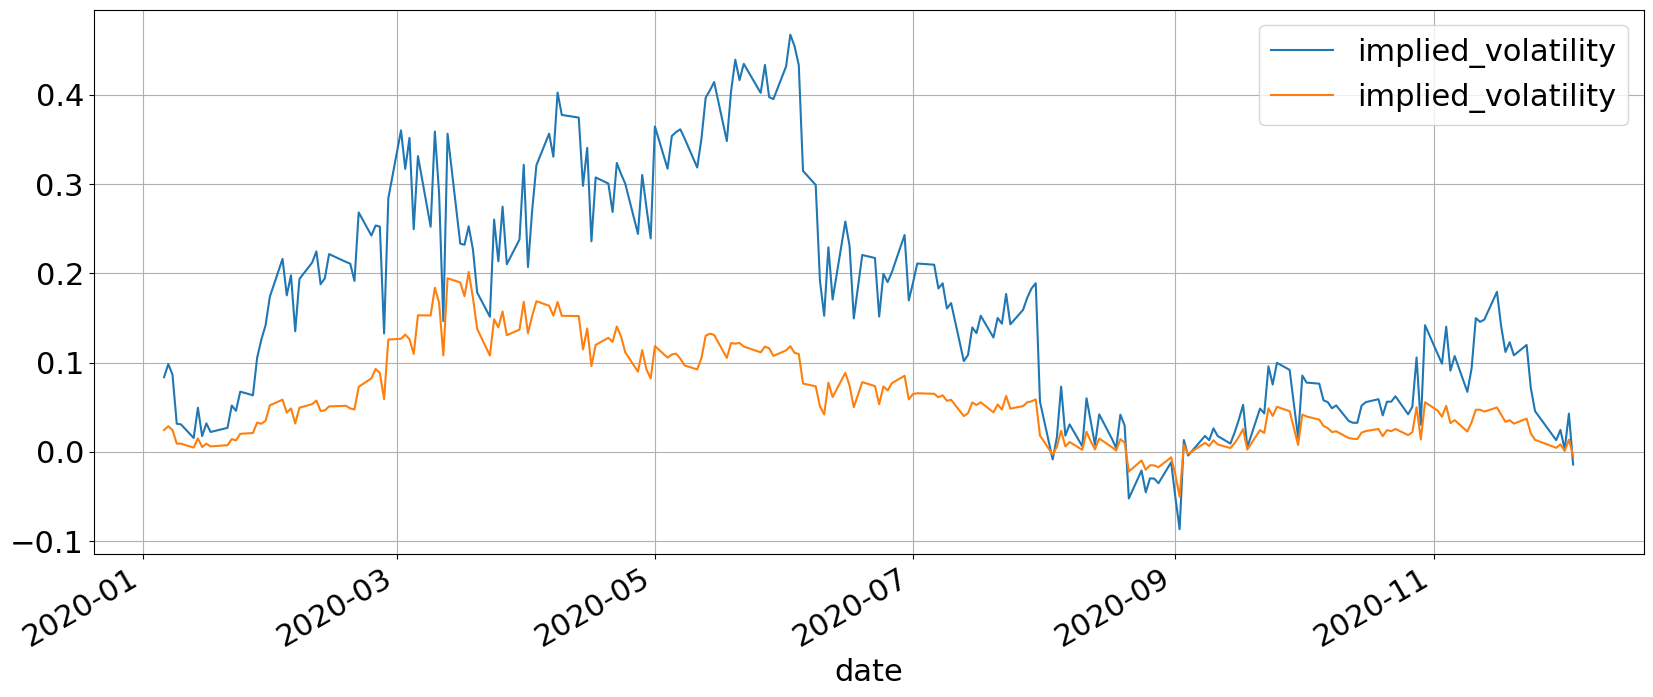

In [26]:
skew_2 = (
    df_selected_90P.set_index("date")[["implied_volatility"]] - df_selected_110C.set_index("date")[["implied_volatility"]]
) / df_selected_100C.set_index("date")[["implied_volatility"]]
skew_1 = df_selected_90P.set_index("date")[["implied_volatility"]] - df_selected_110C.set_index("date")[["implied_volatility"]]


ax = skew_2.plot(grid=True, figsize=(20, 8))
skew_1.plot(grid=True, figsize=(20, 8), ax=ax)

<Axes: xlabel='date'>

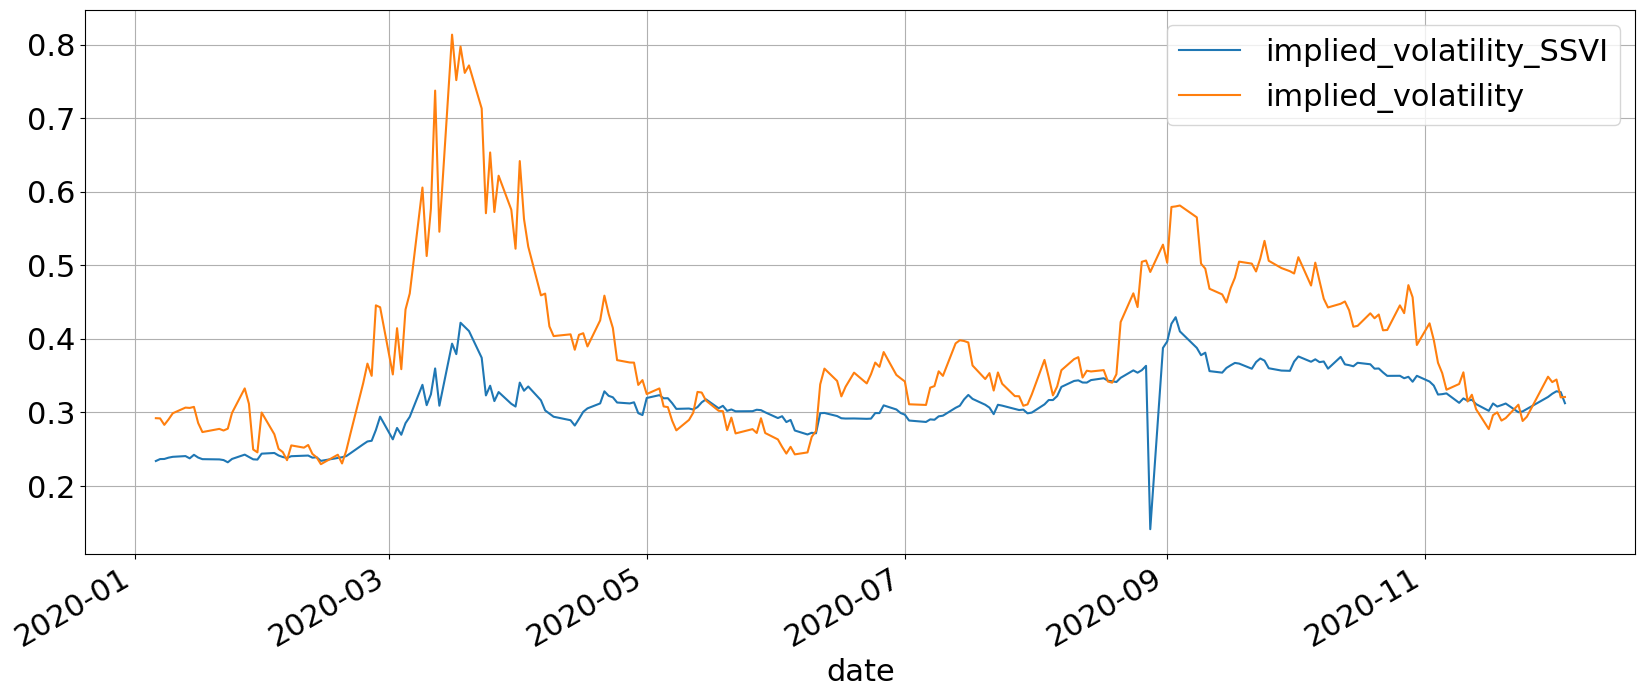

In [29]:
df_selected_100C.set_index("date")[["implied_volatility_SSVI", "implied_volatility"]].plot(grid=True, figsize=(20, 8))